# Educational Curriculum Product Review Analysis: Eureka Math by Great Minds

In [1]:
#Reddit Scraper Library
import praw
from praw.models import MoreComments
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Sentiment Analysis Library
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

#Keyword Extractor
from rake_nltk import Rake

#Topic Modelling Library
from gensim import corpora
from gensim.models import LsiModel
from gensim.models import LdaModel

#Word Cloud Visualization Library
from wordcloud import WordCloud

#T5 Summarizer
#from transformers import T5Tokenizer, TFT5ForConditionalGeneration

### Build Reddit Scraper

In [2]:
#Initiate Reddit Instance
reddit = praw.Reddit(
    client_id="z3DgdGeM3hPFNuru2P3FGQ",
    client_secret="NtBXsZsU0PPq3_mlwtahh3gAk5MWXg",
    user_agent="r/teacher scraper by u/carlschwabb",
)

In [251]:
'''submissionList = []
submission.comments.replace_more(limit=None)
for comment in submission.comments.list():
    submissionList.append(comment)'''

'submissionList = []\nsubmission.comments.replace_more(limit=None)\nfor comment in submission.comments.list():\n    submissionList.append(comment)'

In [252]:
'''def getSubComments(comment, allComments, verbose=True):
  allComments.append(comment)
  if not hasattr(comment, "replies"):
    replies = comment.comments()
    if verbose: print("fetching (" + str(len(allComments)) + " comments fetched total)")
  else:
    replies = comment.replies
  for child in replies:
    getSubComments(child, allComments, verbose=verbose)


def getAll(r, submissionId, verbose=True):
  submission = r.submission(submissionId)
  comments = submission.comments
  commentsList = []
  for comment in comments:
    getSubComments(comment, commentsList, verbose=verbose)
  return commentsList'''

'def getSubComments(comment, allComments, verbose=True):\n  allComments.append(comment)\n  if not hasattr(comment, "replies"):\n    replies = comment.comments()\n    if verbose: print("fetching (" + str(len(allComments)) + " comments fetched total)")\n  else:\n    replies = comment.replies\n  for child in replies:\n    getSubComments(child, allComments, verbose=verbose)\n\n\ndef getAll(r, submissionId, verbose=True):\n  submission = r.submission(submissionId)\n  comments = submission.comments\n  commentsList = []\n  for comment in comments:\n    getSubComments(comment, commentsList, verbose=verbose)\n  return commentsList'

### Scrape r/Teachers Subreddit for Posts, Comments, and Replies regarding 'Eureka'

In [3]:
def get_reviews (subreddit, keyword):

    pcr = []
    
    for submission in reddit.subreddit(subreddit).search(keyword, limit=None):
        entry = {'date': submission.created_utc,
                'author': submission.author,
                'title': submission.title,
                'text': submission.selftext,
                'url': submission.url}
        pcr.append(entry)
        for c in submission.comments:
            entry_c = {'date': c.created_utc,
                       'author': c.author,
                       'title': 'comment',
                       'text': c.body,
                       'url': c.permalink}
            pcr.append(entry_c)
            for r in c.replies:
                entry_r = {'date': r.created_utc,
                           'author': r.author,
                           'title': 'reply',
                           'text': r.body,
                           'url': r.permalink}
                pcr.append(entry_r)
                for rr in r.replies:
                    entry_rr = {'date': rr.created_utc,
                                'author': rr.author,
                                'title': 'sub1reply',
                                'text': rr.body,
                                'url': rr.permalink}
                    pcr.append(entry_rr)
                    for rrr in rr.replies:
                        entry_rrr = {'date': rrr.created_utc,
                                     'author': rrr.author,
                                     'title': 'sub2reply',
                                     'text': rrr.body,
                                     'url': rrr.permalink}
                        pcr.append(entry_rrr)
                        for rrrr in rrr.replies:
                            entry_rrrr = {'date': rrrr.created_utc,
                                        'author': rrrr.author,
                                        'title': 'sub3reply',
                                        'text': rrrr.body,
                                        'url': rrrr.permalink}
                            pcr.append(entry_rrrr)
                            for rrrrr in rrrr.replies:
                                entry_rrrrr = {'date': rr.created_utc,
                                            'author': rr.author,
                                            'title': 'sub4reply',
                                            'text': rr.body,
                                            'url': rr.permalink}
    return pcr

In [ ]:
'''
SIMPLIFIED
'''

def extract_entries(entry, title_prefix):
    """
    Recursively extract entries from a submission or comment.
    """
    entries = []
    
    # Create an entry for the current object
    entries.append({
        'date': entry.created_utc,
        'author': entry.author,
        'title': title_prefix,
        'text': entry.body if hasattr(entry, 'body') else entry.selftext,
        'url': entry.permalink if hasattr(entry, 'permalink') else entry.url
    })
    
    # Recursively process replies
    for reply in getattr(entry, 'replies', []):
        entries.extend(extract_entries(reply, f'{title_prefix} reply'))
    
    return entries

def get_reviews(subreddit, keyword):
    """
    Retrieve reviews and their replies from a given subreddit based on a keyword.
    """
    pcr = []
    
    for submission in reddit.subreddit(subreddit).search(keyword, limit=None):
        # Process the submission itself
        pcr.extend(extract_entries(submission, 'submission'))
        
        # Process comments
        for comment in submission.comments:
            pcr.extend(extract_entries(comment, 'comment'))
    
    return pcr

In [4]:
pcr = get_reviews('Teachers', 'eureka');

In [7]:
len(pcr)

1490

### Create DataFrame from List of Reddit Reviews

In [8]:
df = pd.DataFrame.from_records(pcr)

In [9]:
df.head()

,date,author,title,text,url
0,1.723591e+09,Expert_Midnight_7677,Eureka math for combo class?,Has anyone taught Eureka math to 1st and 2nd g...,https://www.reddit.com/r/Teachers/comments/1er...
1,1.723599e+09,Tiredanddontcare,comment,Not first and second but I did teach 3rd and 4...,/r/Teachers/comments/1erm9cz/eureka_math_for_c...
2,1.710810e+09,maaximo,Eureka squared,Anyone using this? Specifically the 7/8 compac...,https://www.reddit.com/r/Teachers/comments/1bi...
3,1.721157e+09,Latter_Text4725,Eureka SQUARED 8th & 7th grade Slides,"Hi there, \n\n \nThis is my 4th year teaching...",https://www.reddit.com/r/Teachers/comments/1e4...
4,1.705602e+09,Reasonable_Cover3220,Eureka Math Citation,Hello! I am doing my EdTPA and i am wondering ...,https://www.reddit.com/r/Teachers/comments/199...


In [10]:
#Convert Epoch time to DateTime
df['date'] = pd.to_datetime(df['date'], unit='s')
df

,date,author,title,text,url
0,2024-08-13 23:24:56,Expert_Midnight_7677,Eureka math for combo class?,Has anyone taught Eureka math to 1st and 2nd g...,https://www.reddit.com/r/Teachers/comments/1er...
1,2024-08-14 01:27:39,Tiredanddontcare,comment,Not first and second but I did teach 3rd and 4...,/r/Teachers/comments/1erm9cz/eureka_math_for_c...
2,2024-03-19 01:06:58,maaximo,Eureka squared,Anyone using this? Specifically the 7/8 compac...,https://www.reddit.com/r/Teachers/comments/1bi...
3,2024-07-16 19:10:48,Latter_Text4725,Eureka SQUARED 8th & 7th grade Slides,"Hi there, \n\n \nThis is my 4th year teaching...",https://www.reddit.com/r/Teachers/comments/1e4...
4,2024-01-18 18:27:28,Reasonable_Cover3220,Eureka Math Citation,Hello! I am doing my EdTPA and i am wondering ...,https://www.reddit.com/r/Teachers/comments/199...
...,...,...,...,...,...
1485,2022-07-28 05:21:49,Birdsongbee,reply,The new one actually is! The word problems are...,/r/Teachers/comments/w9m0ur/if_you_could_pick_...
1486,2022-07-28 02:36:16,Dls1989,comment,"From what I have experience, math in focus was...",/r/Teachers/comments/w9m0ur/if_you_could_pick_...
1487,2022-07-27 20:57:46,ownersequity,comment,The dollar sign! As soon as I make problems ab...,/r/Teachers/comments/w9m0ur/if_you_could_pick_...
1488,2022-07-28 05:00:58,csplonk,comment,ST math is awesome for ELL’s. All puzzle based...,/r/Teachers/comments/w9m0ur/if_you_could_pick_...


### Preprocess Reviews for Sentiment Analysis with NLTK

In [11]:
#Create function to preprocess reviews
def preprocess_text(text):

    #convert all words to lower case
    tokens = word_tokenize(text.lower()) 
    
    #tokenize
    filtered_tokens = []
    for token in tokens: 
        if token not in stopwords.words('english') and token.isalnum():
            filtered_tokens.append(token)
    
    #lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    for token in filtered_tokens:
        lemmatized_tokens.append(lemmatizer.lemmatize(token))
    
    #compile processed text
    processed_text = ' '.join(lemmatized_tokens)

    return processed_text

In [12]:
#Apply function to reviews
df['reviewedText'] = df['text'].apply(preprocess_text)

In [13]:
#Identify which reviews explicitly or implicitly refer to Eureka    
def explicit(df):
    if 'eureka' in df:
        return ('yes')
    else:
        return ('no') 

In [14]:
df['explicit'] = df['reviewedText'].apply(explicit)

In [15]:
df.head()

,date,author,title,text,url,reviewedText,explicit
0,2024-08-13 23:24:56,Expert_Midnight_7677,Eureka math for combo class?,Has anyone taught Eureka math to 1st and 2nd g...,https://www.reddit.com/r/Teachers/comments/1er...,anyone taught eureka math 1st 2nd grade togeth...,yes
1,2024-08-14 01:27:39,Tiredanddontcare,comment,Not first and second but I did teach 3rd and 4...,/r/Teachers/comments/1erm9cz/eureka_math_for_c...,first second teach 3rd 4th together able use z...,yes
2,2024-03-19 01:06:58,maaximo,Eureka squared,Anyone using this? Specifically the 7/8 compac...,https://www.reddit.com/r/Teachers/comments/1bi...,anyone using specifically compacted curriculum...,no
3,2024-07-16 19:10:48,Latter_Text4725,Eureka SQUARED 8th & 7th grade Slides,"Hi there, \n\n \nThis is my 4th year teaching...",https://www.reddit.com/r/Teachers/comments/1e4...,hi 4th year teaching 4th new curriculum wooo s...,yes
4,2024-01-18 18:27:28,Reasonable_Cover3220,Eureka Math Citation,Hello! I am doing my EdTPA and i am wondering ...,https://www.reddit.com/r/Teachers/comments/199...,hello edtpa wondering cite eureka math grade f...,yes


In [16]:
df['explicit'].value_counts()

explicit
no     1350
yes     140
Name: count, dtype: int64

In [17]:
len(df)

1490

In [18]:
df['text'][1]

'Not first and second but I did teach 3rd and 4th together. We were able to use Zearn math which was just Eureka math in a digital format. You can look into that if you have devices at your disposal.'

In [19]:
df['reviewedText'][1]

'first second teach 3rd 4th together able use zearn math eureka math digital format look device disposal'

### Sentiment Analyzer with NLTK \
Doc: https://github.com/cjhutto/vaderSentiment

In [20]:
#Initiate Sentiment Analyzer instance
analyzer = SentimentIntensityAnalyzer()

In [21]:
def polarity_scores(text):
    scores = []
    
    for sentence in text :
        spread=analyzer.polarity_scores(sentence)
        scores.append(spread)

    return scores

In [22]:
pscoresdf = pd.DataFrame(polarity_scores(df['reviewedText']))

In [23]:
pscoresdf

,neg,neu,pos,compound
0,0.000,0.781,0.219,0.6369
1,0.000,1.000,0.000,0.0000
2,0.000,0.706,0.294,0.3612
3,0.045,0.882,0.073,0.1280
4,0.000,0.838,0.162,0.4019
...,...,...,...,...
1485,0.419,0.581,0.000,-0.8689
1486,0.294,0.532,0.174,-0.8779
1487,0.237,0.526,0.237,0.0000
1488,0.000,0.687,0.313,0.6249


In [24]:
df = df.join(pscoresdf)

In [25]:
df

,date,author,title,text,url,reviewedText,explicit,neg,neu,pos,compound
0,2024-08-13 23:24:56,Expert_Midnight_7677,Eureka math for combo class?,Has anyone taught Eureka math to 1st and 2nd g...,https://www.reddit.com/r/Teachers/comments/1er...,anyone taught eureka math 1st 2nd grade togeth...,yes,0.000,0.781,0.219,0.6369
1,2024-08-14 01:27:39,Tiredanddontcare,comment,Not first and second but I did teach 3rd and 4...,/r/Teachers/comments/1erm9cz/eureka_math_for_c...,first second teach 3rd 4th together able use z...,yes,0.000,1.000,0.000,0.0000
2,2024-03-19 01:06:58,maaximo,Eureka squared,Anyone using this? Specifically the 7/8 compac...,https://www.reddit.com/r/Teachers/comments/1bi...,anyone using specifically compacted curriculum...,no,0.000,0.706,0.294,0.3612
3,2024-07-16 19:10:48,Latter_Text4725,Eureka SQUARED 8th & 7th grade Slides,"Hi there, \n\n \nThis is my 4th year teaching...",https://www.reddit.com/r/Teachers/comments/1e4...,hi 4th year teaching 4th new curriculum wooo s...,yes,0.045,0.882,0.073,0.1280
4,2024-01-18 18:27:28,Reasonable_Cover3220,Eureka Math Citation,Hello! I am doing my EdTPA and i am wondering ...,https://www.reddit.com/r/Teachers/comments/199...,hello edtpa wondering cite eureka math grade f...,yes,0.000,0.838,0.162,0.4019
...,...,...,...,...,...,...,...,...,...,...,...
1485,2022-07-28 05:21:49,Birdsongbee,reply,The new one actually is! The word problems are...,/r/Teachers/comments/w9m0ur/if_you_could_pick_...,new one actually word problem much decodable p...,no,0.419,0.581,0.000,-0.8689
1486,2022-07-28 02:36:16,Dls1989,comment,"From what I have experience, math in focus was...",/r/Teachers/comments/w9m0ur/if_you_could_pick_...,experience math focus absolute worst honestly ...,no,0.294,0.532,0.174,-0.8779
1487,2022-07-27 20:57:46,ownersequity,comment,The dollar sign! As soon as I make problems ab...,/r/Teachers/comments/w9m0ur/if_you_could_pick_...,dollar sign soon make problem money student in...,no,0.237,0.526,0.237,0.0000
1488,2022-07-28 05:00:58,csplonk,comment,ST math is awesome for ELL’s. All puzzle based...,/r/Teachers/comments/w9m0ur/if_you_could_pick_...,st math awesome ell puzzle based logic math co...,no,0.000,0.687,0.313,0.6249


In [26]:
#Gauge Sentiment
def sentiment(val):
    if val >= 0.05:
        return 'positive'
    elif val > -0.05 and val < 0.05:
        return 'neutral'
    elif val <= -0.05:
        return 'negative'

In [27]:
#Apply Sentiment Function to Categorize Compound Scores
df['sentiment'] = df['compound'].apply(lambda val: sentiment(val))

In [28]:
df

,date,author,title,text,url,reviewedText,explicit,neg,neu,pos,compound,sentiment
0,2024-08-13 23:24:56,Expert_Midnight_7677,Eureka math for combo class?,Has anyone taught Eureka math to 1st and 2nd g...,https://www.reddit.com/r/Teachers/comments/1er...,anyone taught eureka math 1st 2nd grade togeth...,yes,0.000,0.781,0.219,0.6369,positive
1,2024-08-14 01:27:39,Tiredanddontcare,comment,Not first and second but I did teach 3rd and 4...,/r/Teachers/comments/1erm9cz/eureka_math_for_c...,first second teach 3rd 4th together able use z...,yes,0.000,1.000,0.000,0.0000,neutral
2,2024-03-19 01:06:58,maaximo,Eureka squared,Anyone using this? Specifically the 7/8 compac...,https://www.reddit.com/r/Teachers/comments/1bi...,anyone using specifically compacted curriculum...,no,0.000,0.706,0.294,0.3612,positive
3,2024-07-16 19:10:48,Latter_Text4725,Eureka SQUARED 8th & 7th grade Slides,"Hi there, \n\n \nThis is my 4th year teaching...",https://www.reddit.com/r/Teachers/comments/1e4...,hi 4th year teaching 4th new curriculum wooo s...,yes,0.045,0.882,0.073,0.1280,positive
4,2024-01-18 18:27:28,Reasonable_Cover3220,Eureka Math Citation,Hello! I am doing my EdTPA and i am wondering ...,https://www.reddit.com/r/Teachers/comments/199...,hello edtpa wondering cite eureka math grade f...,yes,0.000,0.838,0.162,0.4019,positive
...,...,...,...,...,...,...,...,...,...,...,...,...
1485,2022-07-28 05:21:49,Birdsongbee,reply,The new one actually is! The word problems are...,/r/Teachers/comments/w9m0ur/if_you_could_pick_...,new one actually word problem much decodable p...,no,0.419,0.581,0.000,-0.8689,negative
1486,2022-07-28 02:36:16,Dls1989,comment,"From what I have experience, math in focus was...",/r/Teachers/comments/w9m0ur/if_you_could_pick_...,experience math focus absolute worst honestly ...,no,0.294,0.532,0.174,-0.8779,negative
1487,2022-07-27 20:57:46,ownersequity,comment,The dollar sign! As soon as I make problems ab...,/r/Teachers/comments/w9m0ur/if_you_could_pick_...,dollar sign soon make problem money student in...,no,0.237,0.526,0.237,0.0000,neutral
1488,2022-07-28 05:00:58,csplonk,comment,ST math is awesome for ELL’s. All puzzle based...,/r/Teachers/comments/w9m0ur/if_you_could_pick_...,st math awesome ell puzzle based logic math co...,no,0.000,0.687,0.313,0.6249,positive


#### Sentiment Analysis for All Entries

In [29]:
#Plot Distribution of Sentiment
yaxis = df['sentiment'].value_counts().to_list()
xaxis = ['Positive', 'Neutral', 'Negative']

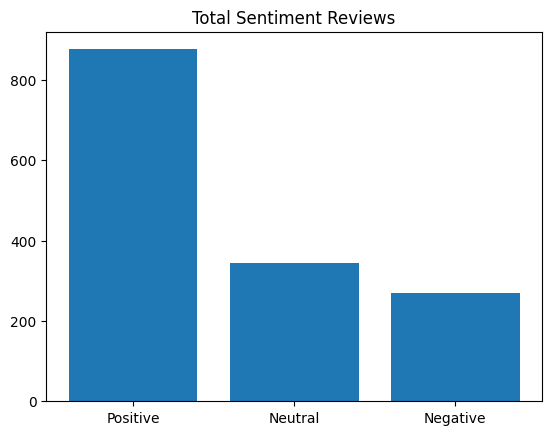

In [30]:
plt.bar(xaxis,yaxis)
plt.title('Total Sentiment Reviews')
plt.show()

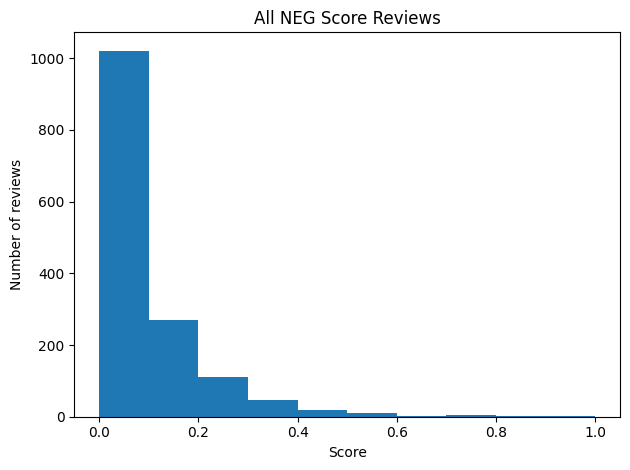

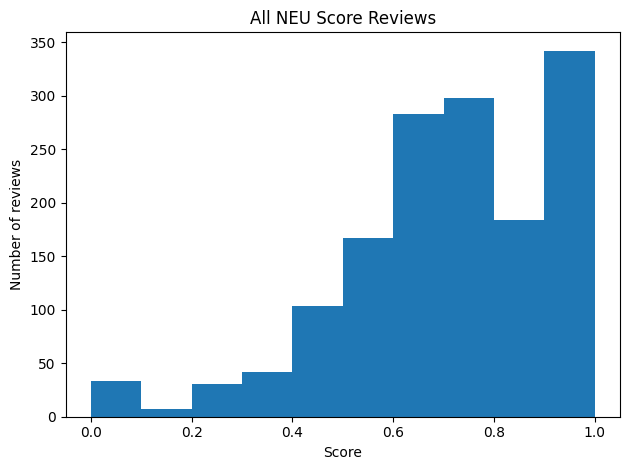

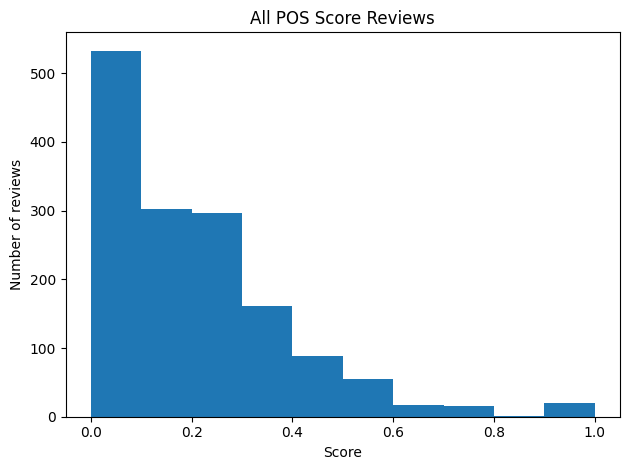

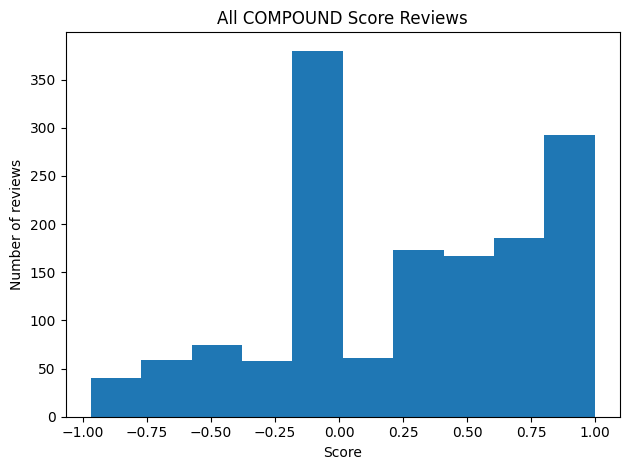

In [31]:
#Plot Distribution of Pos, Neg, Neutral

for c in df.columns[7:11]:
    plt.hist(pscoresdf[c])
    plt.xlabel('Score')
    plt.ylabel('Number of reviews')
    plt.title(f'All {c.upper()} Score Reviews')
    plt.tight_layout()
    plt.show()

#### Sentiment Analysis for Entries Explicitly about 'Eureka'

In [32]:
#Isolate Rows where the text explicitly mentions 'Eureka'
expdf=df.loc[df['explicit'] == 'yes']
expdf

,date,author,title,text,url,reviewedText,explicit,neg,neu,pos,compound,sentiment
0,2024-08-13 23:24:56,Expert_Midnight_7677,Eureka math for combo class?,Has anyone taught Eureka math to 1st and 2nd g...,https://www.reddit.com/r/Teachers/comments/1er...,anyone taught eureka math 1st 2nd grade togeth...,yes,0.000,0.781,0.219,0.6369,positive
1,2024-08-14 01:27:39,Tiredanddontcare,comment,Not first and second but I did teach 3rd and 4...,/r/Teachers/comments/1erm9cz/eureka_math_for_c...,first second teach 3rd 4th together able use z...,yes,0.000,1.000,0.000,0.0000,neutral
3,2024-07-16 19:10:48,Latter_Text4725,Eureka SQUARED 8th & 7th grade Slides,"Hi there, \n\n \nThis is my 4th year teaching...",https://www.reddit.com/r/Teachers/comments/1e4...,hi 4th year teaching 4th new curriculum wooo s...,yes,0.045,0.882,0.073,0.1280,positive
4,2024-01-18 18:27:28,Reasonable_Cover3220,Eureka Math Citation,Hello! I am doing my EdTPA and i am wondering ...,https://www.reddit.com/r/Teachers/comments/199...,hello edtpa wondering cite eureka math grade f...,yes,0.000,0.838,0.162,0.4019,positive
7,2023-09-27 21:47:25,Surrybee,Eureka math squared,Edit: Daughter's in bed now so it's no longer ...,https://www.reddit.com/r/Teachers/comments/16t...,edit daughter bed longer needed tonight someon...,yes,0.106,0.656,0.238,0.9209,positive
...,...,...,...,...,...,...,...,...,...,...,...,...
1469,2022-07-27 20:02:24,Blondiemath,comment,Just going to say the one you don’t want: Expr...,/r/Teachers/comments/w9m0ur/if_you_could_pick_...,going say one want expression degree math well...,yes,0.145,0.601,0.254,0.2732,positive
1470,2022-07-27 22:07:21,Radiant-Salad-9772,reply,Eureka was not ELL friendly in my opinion,/r/Teachers/comments/w9m0ur/if_you_could_pick_...,eureka ell friendly opinion,yes,0.000,0.484,0.516,0.4939,positive
1475,2022-07-27 20:48:34,pumpkinotter,comment,My school is 70% ELL and use Eureka math. What...,/r/Teachers/comments/w9m0ur/if_you_could_pick_...,school 70 ell use eureka math love even using ...,yes,0.095,0.632,0.274,0.7269,positive
1483,2022-07-27 22:36:29,queeenbarb,comment,eureka. but no script. idk what they need to d...,/r/Teachers/comments/w9m0ur/if_you_could_pick_...,eureka script idk need get rid script need get...,yes,0.044,0.596,0.361,0.9022,positive


In [33]:
#Plot Distribution of Sentiment (explicit)
yexp = expdf['sentiment'].value_counts().to_list()
xexp = ['Positive', 'Neutral', 'Negative']

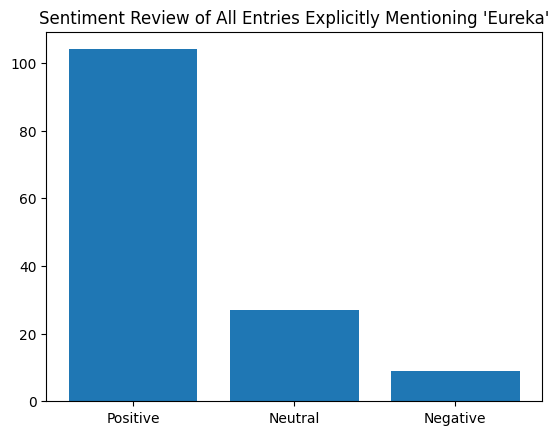

In [34]:
plt.bar(xexp,yexp)
plt.title("Sentiment Review of All Entries Explicitly Mentioning 'Eureka'")
plt.show()

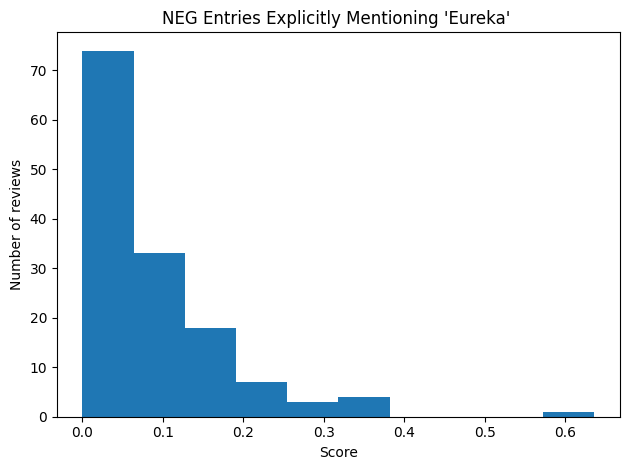

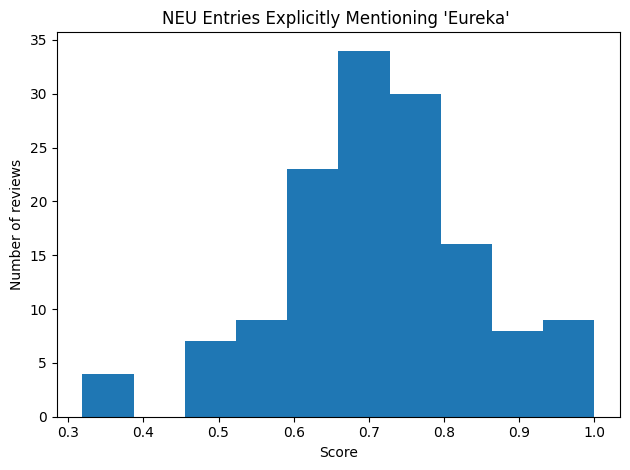

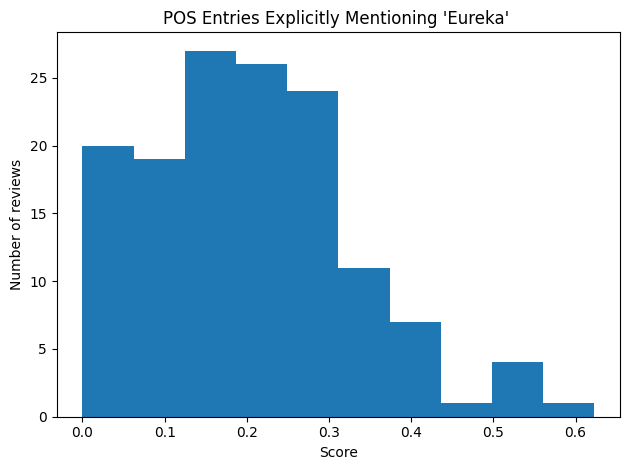

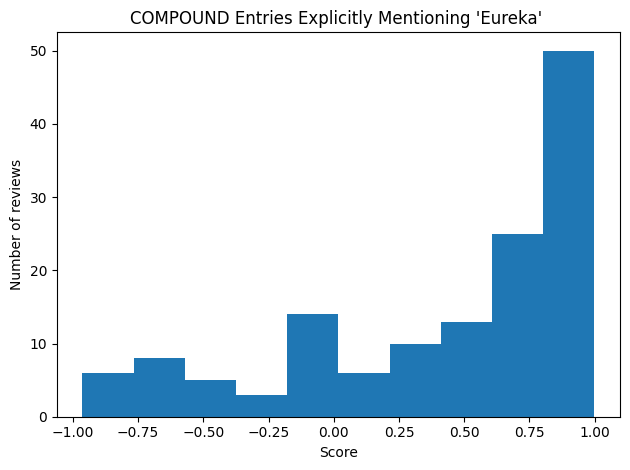

In [35]:
#Plot Distribution of Pos, Neg, Neutral (explicit)
for c in expdf.columns[7:11]:
    plt.hist(expdf[c])
    plt.xlabel('Score')
    plt.ylabel('Number of reviews')
    plt.title(f"{c.upper()} Entries Explicitly Mentioning 'Eureka' ")
    plt.tight_layout()
    plt.show()

### Keyword Extractor
Credit: Manmohan Singh \
https://towardsdatascience.com/keyword-extraction-process-in-python-with-natural-language-processing-nlp-d769a9069d5c

In [108]:
rake_nltk_var = Rake()

In [121]:
rake_nltk_var.extract_keywords_from_text(expdf['text'][1])

In [122]:
keywords_extracted = rake_nltk_var.get_ranked_phrases()

In [123]:
print(keywords_extracted)

['8th grade eureka squared', 'ive already reached', 'download entire modules', '4th year teaching', '4th new curriculum', 'slides already made', 'eureka squared', 'wooo !!)', 'whole module', 'throw away', 'summer making', 'slides provided', 'individual lessons', 'slides', 'eureka', 'eureka', 'way', 'wanted', 'unfortunately', 'time', 'time', 'thank', 'test', 'switching', 'rest', 'ps', 'lesson', 'lesson', 'hi', 'creators', 'anyone', '7th']


In [113]:
expdf['text'][1]

'Hi there, \n\n  \nThis is my 4th year teaching & my 4th new curriculum. (WOOO!!)  We are switching to Eureka Squared from Eureka. Unfortunately, the slides provided are only lesson by lesson & not a whole module at a time. Does anyone have  slides already made for 7th or 8th grade Eureka Squared? I wanted to test this out before I throw away the rest of my summer making these slides. \n\n  \nThank you! \n\n  \nPS: Ive already reached out to the creators of Eureka and there is no way to download entire modules. Only individual lessons at a time. '

In [114]:
expdf.sort_values(by=['compound'], ascending=True)['text'][1094]

'I had a bit of a confrontation with our CSP today. They came to me during my lunch break and wanted to know where I was in Eureka Math and began wanting to know what our "Highly Leveraged Standards" for the quarter were. I told her we are working on subtraction within 1000 with borrowing and I am reviewing it in tens and 100s because I was out sick and my kids missed it. They went off on a rant and said that "No, Eureka says that you should be a blah blah blah and you have to move on." I asked, to clarify, if I was supposed to skip teaching subtraction to teach arrays, thus having kids leaving 2nd grade without being capable of adding and subtracting, but having some knowledge of arrays and fucking tape charts. I said, "No. I am not going to have kids leave my class not knowing how to add and subtract, that is the building blocks of everything else and its developmentally where they are at , Eureka is absolute crap and its the problem." We had a few more words and I said, "My kids wil

In [136]:
rake_nltk_var.extract_keywords_from_text(expdf['text'][1094])

In [137]:
keywords_extracted = rake_nltk_var.get_ranked_phrases()

In [138]:
print(keywords_extracted)

['kids leaving 2nd grade without', 'tanked every year since eureka', 'every damn year', 'subtraction within 1000', 'skip teaching subtraction', 'highly leveraged standards', 'fucking tape charts', 'blah blah blah', '3rd grade', 'kids missed', 'kids leave', 'eureka says', 'eureka math', 'lunch break', 'hemorrhaging students', 'everything else', 'csp today', 'building blocks', 'began wanting', 'absolute crap', 'test scores', 'problem ."', 'teach arrays', 'kids', 'eureka', 'test', 'teach', 'arrays', '."', '."', 'working', 'words', 'went', 'wanted', 'told', 'thus', 'tens', 'taught', 'supposed', 'subtracting', 'subtract', 'sick', 'said', 'said', 'said', 'reviewing', 'ready', 'ready', 'rant', 'quarter', 'move', 'like', 'level', 'knowledge', 'knowing', 'know', 'know', 'insanity', 'going', 'encountered', 'districts', 'district', 'developmentally', 'curriculum', 'confrontation', 'class', 'clarify', 'charters', 'capable', 'came', 'brought', 'borrowing', 'bit', 'asked', 'also', 'adding', 'add', '

In [94]:
expdf.sort_values(by=['compound'], ascending=True)['text'][:100]

1094    I had a bit of a confrontation with our CSP to...
1362    To make a very long story short- I am a first ...
1187    STORY TIME\n\nBackground - I’m an elementary s...
1425    I don't know anything about Gary Rubinstein.  ...
279     Yikes. This is what the modern GOP has come to...
                              ...                        
1226    I’m going to teach 1st grade for the first tim...
1240    I will say, having all the copies done for Eur...
79      My county is starting Eureka k-5 this upcoming...
26      Our district is starting Eureka Math next year...
1086    What does vertical alignment look like for com...
Name: text, Length: 100, dtype: object

### Topic Modelling of Negative Reviews with Gensim 
Credit: Kurtis Pykes https://www.datacamp.com/tutorial/what-is-topic-modeling \
Doc: https://radimrehurek.com/gensim/models/lsimodel.html

In [36]:
#Create DataFrame of only Negative entries

''' There are only 27 negative reviews explicitly about 'Eureka' '''

negdf = expdf.loc[expdf['sentiment'] == 'negative'].sort_values(by='compound', ascending=True)

#### LSA Model (Latent Semantic Analysis)

In [37]:
def lsaModel (reviewedText):
    corpus = [i.split() for i in reviewedText]
    dictionary = corpora.Dictionary(corpus)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in corpus]
    lsa = LsiModel(doc_term_matrix, num_topics=3, id2word=dictionary)
    return lsa

In [38]:
lsa = lsaModel(negdf['reviewedText'])

In [39]:
pprint(lsa.print_topics(num_topics=-1, num_words=10))

[(0,
  '0.419*"math" + 0.318*"student" + 0.255*"eureka" + 0.252*"grade" + '
  '0.237*"teacher" + 0.214*"year" + 0.157*"lesson" + 0.147*"curriculum" + '
  '0.146*"kid" + 0.144*"teaching"'),
 (1,
  '0.303*"math" + 0.261*"know" + -0.243*"teacher" + -0.187*"year" + '
  '-0.184*"student" + 0.179*"eureka" + -0.173*"grade" + -0.167*"help" + '
  '-0.164*"day" + 0.149*"curriculum"'),
 (2,
  '0.300*"wrong" + 0.282*"student" + 0.232*"lesson" + -0.226*"grade" + '
  '-0.196*"teacher" + 0.181*"slide" + 0.180*"back" + 0.155*"taught" + '
  '-0.153*"year" + -0.147*"know"')]


In [40]:
pprint(lsa.show_topics(num_topics=-1, num_words=30, log=False, formatted=True))

[(0,
  '0.419*"math" + 0.318*"student" + 0.255*"eureka" + 0.252*"grade" + '
  '0.237*"teacher" + 0.214*"year" + 0.157*"lesson" + 0.147*"curriculum" + '
  '0.146*"kid" + 0.144*"teaching" + 0.142*"know" + 0.125*"first" + '
  '0.125*"teach" + 0.121*"help" + 0.110*"classroom" + 0.110*"school" + '
  '0.102*"day" + 0.100*"wrong" + 0.095*"taught" + 0.093*"even" + '
  '0.092*"district" + 0.086*"problem" + 0.081*"3rd" + 0.074*"also" + '
  '0.068*"hard" + 0.063*"say" + 0.062*"4th" + 0.062*"time" + 0.060*"work" + '
  '0.060*"need"'),
 (1,
  '0.303*"math" + 0.261*"know" + -0.243*"teacher" + -0.187*"year" + '
  '-0.184*"student" + 0.179*"eureka" + -0.173*"grade" + -0.167*"help" + '
  '-0.164*"day" + 0.149*"curriculum" + 0.138*"textbook" + 0.138*"rather" + '
  '0.126*"teach" + -0.125*"first" + 0.123*"problem" + -0.123*"classroom" + '
  '0.110*"use" + 0.098*"core" + 0.093*"one" + 0.092*"site" + 0.092*"camp" + '
  '0.092*"follow" + 0.092*"link" + 0.092*"supplement" + 0.092*"perfect" + '
  '0.092*"mist

#### LDA Model (Latent Dirichlet Allocation)

In [41]:
def ldaModel (reviewedText):
    corpus = [i.split() for i in reviewedText]
    dictionary = corpora.Dictionary(corpus)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in corpus]
    lda = LdaModel(doc_term_matrix, num_topics=3, id2word=dictionary)
    return lda

In [42]:
lda = ldaModel(negdf['reviewedText'])

In [43]:
pprint(lda.print_topics(num_topics=-1, num_words=30))

[(0,
  '0.027*"math" + 0.020*"student" + 0.018*"eureka" + 0.014*"teacher" + '
  '0.013*"grade" + 0.013*"curriculum" + 0.012*"year" + 0.011*"teaching" + '
  '0.010*"kid" + 0.010*"problem" + 0.007*"lesson" + 0.007*"school" + '
  '0.007*"teach" + 0.006*"first" + 0.006*"know" + 0.006*"class" + '
  '0.005*"wrong" + 0.005*"district" + 0.005*"taught" + 0.005*"went" + '
  '0.004*"day" + 0.004*"help" + 0.004*"time" + 0.004*"hard" + 0.004*"even" + '
  '0.004*"classroom" + 0.004*"question" + 0.004*"work" + 0.004*"would" + '
  '0.004*"word"'),
 (1,
  '0.028*"eureka" + 0.012*"problem" + 0.012*"lesson" + 0.010*"way" + '
  '0.009*"teach" + 0.009*"grade" + 0.008*"new" + 0.008*"wrong" + 0.008*"math" '
  '+ 0.007*"able" + 0.007*"work" + 0.006*"student" + 0.006*"get" + '
  '0.006*"look" + 0.006*"4th" + 0.005*"year" + 0.005*"understand" + '
  '0.005*"district" + 0.005*"make" + 0.005*"core" + 0.005*"different" + '
  '0.005*"teacher" + 0.005*"hate" + 0.005*"exhausting" + 0.005*"squared" + '
  '0.005*"online

In [172]:
ldakw = ldaModel(kwtest)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [45]:
pprint(lda.show_topics(num_topics=-1, num_words=10, log=False, formatted=True))

[(0,
  '0.027*"math" + 0.020*"student" + 0.018*"eureka" + 0.014*"teacher" + '
  '0.013*"grade" + 0.013*"curriculum" + 0.012*"year" + 0.011*"teaching" + '
  '0.010*"kid" + 0.010*"problem"'),
 (1,
  '0.028*"eureka" + 0.012*"problem" + 0.012*"lesson" + 0.010*"way" + '
  '0.009*"teach" + 0.009*"grade" + 0.008*"new" + 0.008*"wrong" + 0.008*"math" '
  '+ 0.007*"able"'),
 (2,
  '0.026*"math" + 0.023*"eureka" + 0.013*"year" + 0.012*"grade" + 0.012*"know" '
  '+ 0.012*"kid" + 0.011*"student" + 0.011*"curriculum" + 0.008*"teacher" + '
  '0.008*"first"')]


In [48]:
len(negdf)

27